I often generate [matplotlib](https://matplotlib.org/) plots that contain thousands of lines, or millions of points. Depending on how these are drawn, this can make for huge (>10MB) PDF files. If a given plot is meant to be included as a figure in a paper, this can then make for even huger manuscript PDF sizes. This post is meant to be a short tip or note about how to slim down plot file sizes when you want to preserve vector graphics for some plot elements and just want to rasterize a large set of, e.g., lines or other matplotlib `Artist` objects. 

First, some imports:

In [1]:
import io
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

Imagine we have time series for 256 objects sampled at 1000 times and we want to plot all of these time series on one matplotlib plot. But, maybe we also want to plot another line on top of these, and we want this other line to be a vector object. For demonstration, let's just generate some fake data with the correct shapes:

In [2]:
data = np.random.normal(np.random.uniform(-10, 10, size=256), size=(1000, 256))

other_line = np.random.uniform(size=1000)

To plot this, we could either loop over the objects and plot them one by one, or construct a 2D array and plot them all in one go. Here, we'll use the 2D array we made above to plot them all in one go. If we save this plot as a PDF, it will be large, and any renderer will draw the lines one-by-one as vector objects:

2.019754 Mbyte


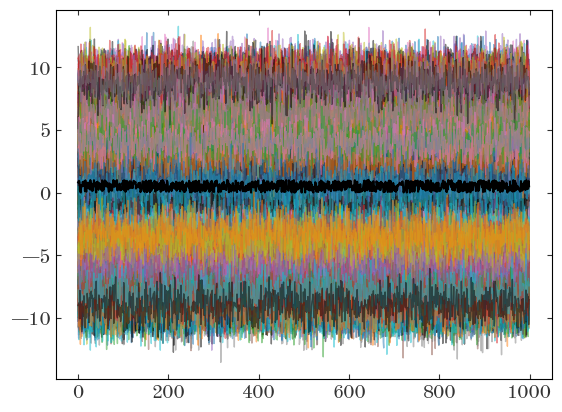

In [3]:
fig, ax = plt.subplots()
ax.plot(data, marker="", linewidth=1.0, alpha=0.5)
ax.plot(other_line, marker="", color="k")

with io.BytesIO() as buffer:
    fig.savefig(buffer, format="pdf", dpi=250)

    filesize = (buffer.getbuffer().nbytes * u.byte).to(u.megabyte)
    print(filesize)

One way I often think to get around this is to use the `rasterized=True` keyword, but this can sometimes lead to unexpected behavior. For example, here, because each line is given its own layer and rasterized separately, using `rasterized=True` actually *increases* the file size:

1.017869 Mbyte


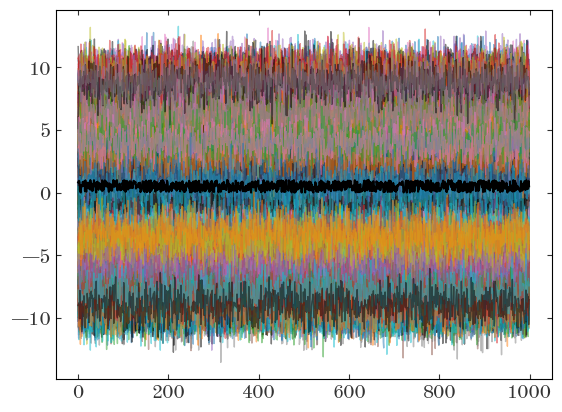

In [4]:
fig, ax = plt.subplots()
ax.plot(data, marker="", linewidth=1.0, alpha=0.5, rasterized=True)
ax.plot(other_line, marker="", color="k")

with io.BytesIO() as buffer:
    fig.savefig(buffer, format="pdf", dpi=250)

    filesize = (buffer.getbuffer().nbytes * u.byte).to(u.megabyte)
    print(filesize)

The solution I keep having to re-discover is to instead use the `matplotlib`'s layering or [`zorder` functionality](https://matplotlib.org/3.1.1/gallery/misc/zorder_demo.html). If we plot all of our lines at or below a given `zorder` value, we can then tell `matplotlib` to rasterize everything below a given `zorder` value *together*. In other words, here, it would rasterize all of the lines into a single image, rather than 256 separate rasterized images. This often leads to the smallest file sizes for cases where you want to rasterize some plot data and not others:

0.986053 Mbyte


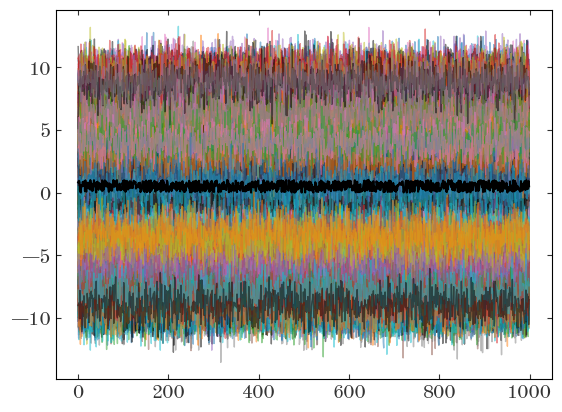

In [5]:
fig, ax = plt.subplots()
ax.plot(data, marker="", linewidth=1.0, alpha=0.5, zorder=-10)
ax.set_rasterization_zorder(0)

ax.plot(other_line, marker="", color="k")

with io.BytesIO() as buffer:
    fig.savefig(buffer, format="pdf", dpi=250)

    filesize = (buffer.getbuffer().nbytes * u.byte).to(u.megabyte)
    print(filesize)